In [1]:
from time import time
import os, sys, csv
import numpy as np
from pylab import *
import pylab as pylab
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from MulticoreTSNE import MulticoreTSNE as TSNE
from scipy import stats

import tensorflow as tf


from kpal.klib import Profile

import pandas as pd

import umap

from sklearn import manifold
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn import svm
import umap
from sklearn.datasets import load_digits
from Bio import SeqIO
from io import StringIO
import sys

#Hyperspherical VAE
from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform


/home/jacob/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pentamer_array = np.load('pentamer.npy')
contig_labels = np.load('contig_labels.npy')

In [3]:
u_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation').fit_transform(pentamer_array)

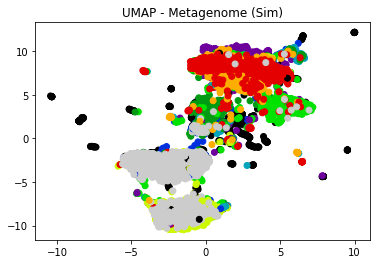

In [5]:
colors = [int(i % 10) for i in contig_labels]
pylab.scatter(u_embedding[:,0], u_embedding[:,1],c=colors,cmap=pylab.cm.spectral)
pylab.title("UMAP - Metagenome (Sim)")
pylab.show()

In [ ]:
def umap_embed(neighbors, metriq):
    u_embedding = umap.UMAP(n_neighbors=10,
                          min_dist=0.3,
                          metric=metriq).fit_transform(pentamer_array)
    return u_embedding

def tsne_embed_fun():
    tsne = TSNE(n_jobs=4)
    return tsne.fit_transform(pentamer_array)

def plot_meta(u_embedding, metric):
    colors = [int(i % 10) for i in contig_labels]
    pylab.scatter(u_embedding[:,0], u_embedding[:,1],c=colors,cmap=pylab.cm.spectral)
    pylab.title("UMAP - Metagenome (Sim, "+ metric+ ")")
    pylab.show()
    return

def train_and_score(em, test_size, kernel):
    X_train, X_test, y_train, y_test = train_test_split(em, contig_labels, test_size=test_size)
    Uclf = svm.SVC(kernel=kernel, C=1).fit(X_train, y_train)
    return Uclf.score(X_test,y_test)

def run_nonsense(neighbors, iter):
    u_euc_scores = []
    u_mah_scores = []
    u_cor_scores = []
    tsne_scores = []

    for i in range(iter):
        print("Begin loop %i" % iter)
        euc_embed = umap_embed(neighbors, 'euclidean')
        u_euc_scores.append(train_and_score(euc_embed, 0.4, 'rbf'))
        print("Finished euc embedding. Score: ", str(u_euc_scores[-1]))

        mah_embed = umap_embed(neighbors, 'mahalanobis')
        u_mah_scores.append(train_and_score(mah_embed, 0.4, 'rbf'))
        print("Finished mah embedding. Score: ", str(u_mah_scores[-1]))


        cor_embed = umap_embed(neighbors, 'correlation')
        u_cor_scores.append(train_and_score(cor_embed, 0.4, 'rbf'))
        print("Finished cor embedding. Score: ", str(u_cor_scores[-1]))

        tsne_embedding = tsne_embed_fun()
        tsne_scores.append(train_and_score(tsne_embedding, 0.4, 'rbf'))
        print("Finished tSNE. Score: ", str(tsne_scores[-1]))
        
        print("loop " + str(i) + " complete.")
    return u_euc_scores, u_mah_scores, u_cor_scores, tsne_scores

In [ ]:
euc_scores_15, mah_scores_15, cor_scores_15, tsne_scores = run_nonsense(15, 2)
print("Euclidean mean (15 neighbors): ", mean(euc_scores_15))
print("Mahalanobis mean (15 neighbors): ", mean(mah_scores_15))
print("Correlation mean (15 neighbors): ", mean(cor_scores_15))
print("tSNE mean: ", mean(tsne_scores))

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data/', one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Function zoo- s-VAE

In [3]:
class ModelVAE(object):

    def __init__(self, x, h_dim, z_dim, activation=tf.nn.relu, distribution='normal'):
        """
        ModelVAE initializer
        :param x: placeholder for input
        :param h_dim: dimension of the hidden layers
        :param z_dim: dimension of the latent representation
        :param activation: callable activation function
        :param distribution: string either `normal` or `vmf`, indicates which distribution to use
        """
        self.x, self.h_dim, self.z_dim, self.activation, self.distribution = x, h_dim, z_dim, activation, distribution

        self.z_mean, self.z_var = self._encoder(self.x)

        if distribution == 'normal':
            self.q_z = tf.distributions.Normal(self.z_mean, self.z_var)
        elif distribution == 'vmf':
            self.q_z = VonMisesFisher(self.z_mean, self.z_var)
        else:
            raise NotImplemented

        self.z = self.q_z.sample()

        self.logits = self._decoder(self.z)

    def _encoder(self, x):
        """
        Encoder network
        :param x: placeholder for input
        :return: tuple `(z_mean, z_var)` with mean and concentration around the mean
        """
        # 2 hidden layers encoder
        h0 = tf.layers.dense(x, units=self.h_dim * 2, activation=self.activation)
        h1 = tf.layers.dense(h0, units=self.h_dim, activation=self.activation)

        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            z_mean = tf.layers.dense(h1, units=self.z_dim, activation=None)
            z_var = tf.layers.dense(h1, units=self.z_dim, activation=tf.nn.softplus)
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            z_mean = tf.layers.dense(h1, units=self.z_dim, activation=lambda x: tf.nn.l2_normalize(x, axis=-1))
            z_var = tf.layers.dense(h1, units=1, activation=tf.nn.softplus)
        else:
            raise NotImplemented

        return z_mean, z_var

    def _decoder(self, z):
        """
        Decoder network
        :param z: tensor, latent representation of input (x)
        :return: logits, `reconstruction = sigmoid(logits)`
        """
        # 2 hidden layers decoder
        h2 = tf.layers.dense(z, units=self.h_dim, activation=self.activation)
        h2 = tf.layers.dense(h2, units=self.h_dim * 2, activation=self.activation)
        logits = tf.layers.dense(h2, units=self.x.shape[-1], activation=None)

        return logits


class OptimizerVAE(object):

    def __init__(self, model, learning_rate=1e-3):
        """
        OptimizerVAE initializer
        :param model: a model object
        :param learning_rate: float, learning rate of the optimizer
        """

        # binary cross entropy error
        self.bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=model.x, logits=model.logits)
        self.reconstruction_loss = tf.reduce_mean(tf.reduce_sum(self.bce, axis=-1))

        if model.distribution == 'normal':
            # KL divergence between normal approximate posterior and standard normal prior
            self.p_z = tf.distributions.Normal(tf.zeros_like(model.z), tf.ones_like(model.z))
            kl = model.q_z.kl_divergence(self.p_z)
            self.kl = tf.reduce_mean(tf.reduce_sum(kl, axis=-1))
        elif model.distribution == 'vmf':
            # KL divergence between vMF approximate posterior and uniform hyper-spherical prior
            self.p_z = HypersphericalUniform(model.z_dim - 1, dtype=model.x.dtype)
            kl = model.q_z.kl_divergence(self.p_z)
            self.kl = tf.reduce_mean(kl)
        else:
            raise NotImplemented

        self.ELBO = - self.reconstruction_loss - self.kl

        self.train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(-self.ELBO)

        self.print = {'recon loss': self.reconstruction_loss, 'ELBO': self.ELBO, 'KL': self.kl}


def log_likelihood(model, optimizer, n=10):
    """
    :param model: model object
    :param optimizer: optimizer object
    :param n: number of MC samples
    :return: MC estimate of log-likelihood
    """

    z = model.q_z.sample(n)

    log_p_z = optimizer.p_z.log_prob(z)

    if model.distribution == 'normal':
        log_p_z = tf.reduce_sum(log_p_z, axis=-1)

    log_p_x_z = -tf.reduce_sum(optimizer.bce, axis=-1)

    log_q_z_x = model.q_z.log_prob(z)

    if model.distribution == 'normal':
        log_q_z_x = tf.reduce_sum(log_q_z_x, axis=-1)

    return tf.reduce_mean(tf.reduce_logsumexp(
        tf.transpose(log_p_x_z + log_p_z - log_q_z_x) - np.log(n), axis=-1))

In [6]:
# hidden dimension and dimension of latent space
H_DIM = 128
Z_DIM = 2

# digit placeholder
x = tf.placeholder(tf.float64, shape=(None, 784))

# normal VAE
modelN = ModelVAE(x=x, h_dim=H_DIM, z_dim=Z_DIM, distribution='normal')
optimizerN = OptimizerVAE(modelN)

# hyper-spherical VAE
modelS = ModelVAE(x=x, h_dim=H_DIM, z_dim=Z_DIM + 1, distribution='vmf')
optimizerS = OptimizerVAE(modelS)

session = tf.Session()
session.run(tf.global_variables_initializer())

print('##### Normal VAE #####')
for i in range(1000):
    # training
    x_mb, _ = mnist.train.next_batch(64)
    session.run(optimizerN.train_step, {modelN.x: x_mb})

    # every 100 iteration plot validation
    if i % 100 == 0:
        x_mb = mnist.validation.images
        print(i, session.run({**optimizerN.print}, {modelN.x: x_mb}))

print('Test set:')
x_mb = mnist.test.images
print_ = {**optimizerN.print}
print_['LL'] = log_likelihood(modelN, optimizerN, n=100)
print(session.run(print_, {modelN.x: x_mb}))

print()
print('##### Hyper-spherical VAE #####')
for i in range(1000):
    # training
    x_mb, _ = mnist.train.next_batch(64)
    session.run(optimizerS.train_step, {modelS.x: x_mb})

    # every 100 iteration plot validation
    if i % 100 == 0:
        x_mb = mnist.validation.images
        print(i, session.run({**optimizerS.print}, {modelS.x: x_mb}))

print('Test set:')
x_mb = mnist.test.images
print_ = {**optimizerS.print}
print_['LL'] = log_likelihood(modelS, optimizerS, n=100)
print(session.run(print_, {modelS.x: x_mb}))

##### Normal VAE #####
0 {'recon loss': 539.7464204387132, 'ELBO': -540.0090596848859, 'KL': 0.2626392461726193}
100 {'recon loss': 199.18223237059578, 'ELBO': -202.01072722923877, 'KL': 2.8284948586429874}
200 {'recon loss': 184.57757057694076, 'ELBO': -188.36027192190048, 'KL': 3.7827013449597158}
300 {'recon loss': 173.06702951117788, 'ELBO': -177.3036668557495, 'KL': 4.236637344571629}
400 {'recon loss': 168.6143110294557, 'ELBO': -173.25306743559116, 'KL': 4.63875640613546}
500 {'recon loss': 165.82521326103225, 'ELBO': -170.61387355276278, 'KL': 4.788660291730538}
600 {'recon loss': 164.59593696090994, 'ELBO': -169.02741016116565, 'KL': 4.431473200255701}
700 {'recon loss': 163.155848564315, 'ELBO': -167.76028647129675, 'KL': 4.60443790698176}
800 {'recon loss': 161.5079381982806, 'ELBO': -166.3040958812118, 'KL': 4.796157682931176}
900 {'recon loss': 160.0926799566545, 'ELBO': -165.03341720526436, 'KL': 4.94073724860986}
Test set:
{'recon loss': 160.15406184980125, 'ELBO': -165.

In [7]:
session.close()